### Importação de Bibliotecas

In [1]:
# Bibliotecas a serem utilizadas
import random
import numpy as np
import pandas as pd
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import seaborn as sns
import matplotlib.pyplot as plt

### Criação de Cenário para Otimização

Criação de ambiente com:

1. Representado por uma matriz
2. Quadrantes com probabilidades de se encontrar sobreviventes
3. Obstáculos, considerados como -100
4. Ponto de saída sendo o ponto [0, 0]
5. Criação de cenário mais complexo (matrix_complex) e cenário simples (matrix_simple)

In [2]:
row_1 = [0, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
row_2 = [0, 0, 0, 0, 0, 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
row_3 = [0, 0, 0, 0, 0, -100, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]
row_4 = [0, 0, -100, 0, 0, 0.5, 0.6, 0.7, 0.8, -100, 0.8, 0.8, 0.8]
row_5 = [0, 0, 0, 0, 0, 0.5, 0.6, 0.7, 0.8, 0.9, 0.9, 0.9, 0.8]
row_6 = [0, 0, 0, 0, 0, 0.5, 0.6, 0.7, 0.8, 0.9, 0.9, 0.9, 0.8]
row_7 = [0, 0, 0, 0, -100, 0.5, 0.6, 0.7, 0.8, 0.9, 0.9, 0.9, 0.8]
row_8 = [0, -100, 0, 0, 0, 0.5, 0.6, 0.7, -100, 0.8, 0.8, 0.8, 0.8]
row_9 = [0, 0, 0, 0, 0, 0.5, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]

matrix_complex = np.matrix([row_1, row_2, row_3, row_4, row_5, row_6, row_7, row_8, row_9])

In [3]:
row_1 = [0, 0, 0, 0, 0]
row_2 = [0, 0, 0, 0, 0]
row_3 = [0, 0, -100, 0.5, 0.5]
row_4 = [0, 0, 0.5, 0.9, 0.9]
row_5 = [0, 0, 0.5, 0.9, 0.9]

matrix_simple = np.matrix([row_1, row_2, row_3, row_4, row_5])

#### Visão Gráfica dos Cenários

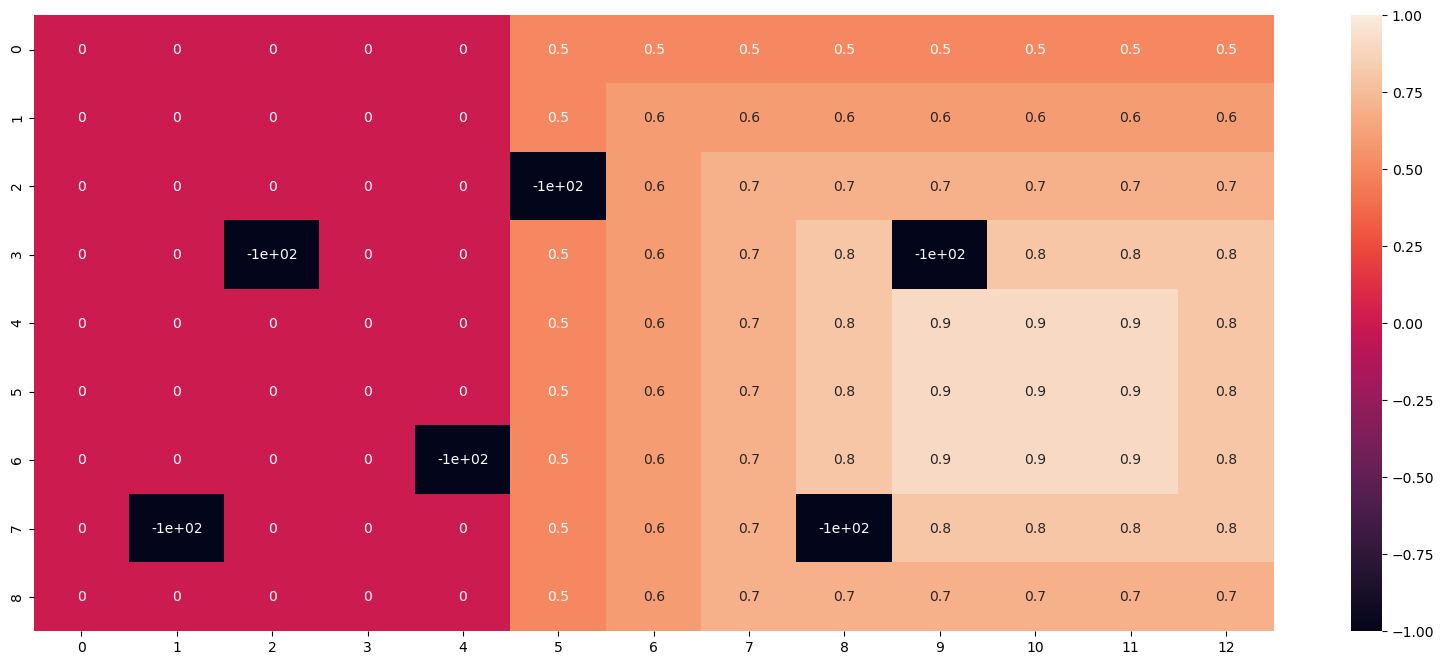

In [4]:
fig, ax = plt.subplots(figsize=(20,8))  

sns.heatmap(matrix_complex, vmin=-1, vmax=1, annot=True)

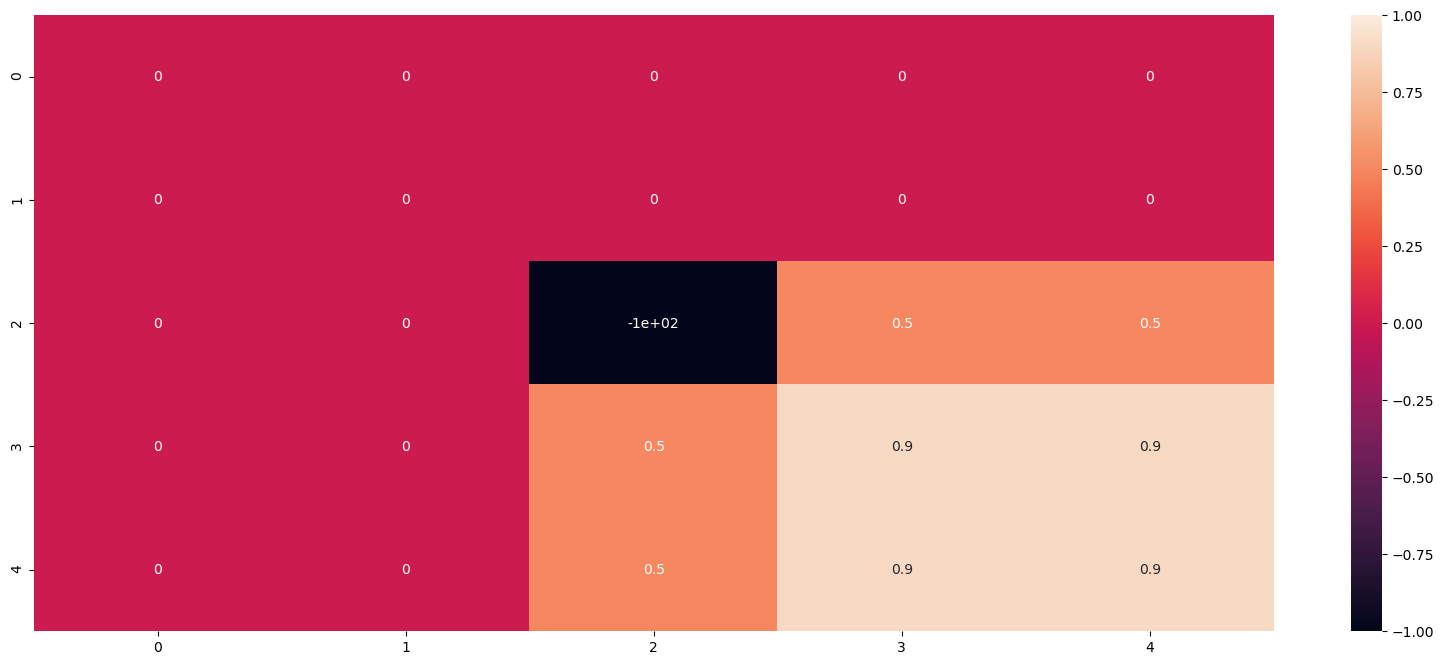

In [5]:
fig, ax = plt.subplots(figsize=(20,8))  

sns.heatmap(matrix_simple, vmin=-1, vmax=1, annot=True)

### Preparação para Otimização

1.   Função de Geração de Indivíduo
2.   Função de Avaliação
3.   Função de Restrição
4.   Função de Penalização

#### Função de Geração de Indivíduo

In [6]:
def individual(matrix):

    posicao_inicial = [0, 0]
    posicao_atual = [0, 0]
    probabilidades_preenchidas = 0
    rota = [[0, 0]]
    vetor_probabilidade_acumulada = [0.0]
    qtd_passos = 1
        
    while probabilidades_preenchidas < np.count_nonzero(matrix>0):

        # Condicional para evitar movimentos ciclicos e explorar todo o ambiente

        #___________________________________________UP____________________________________________

        # Se esta no canto direito inferior e ja foi para esquerda, então vai para cima     
        if (((posicao_atual[0]==matrix.shape[0]-1) and (posicao_atual[1]==matrix.shape[1]-1) and \
            ([(posicao_atual[0]), posicao_atual[1]-1] in rota) and \
            (([(posicao_atual[0])-1, posicao_atual[1]] in rota)==False) and (matrix[tuple([posicao_atual[0]-1, posicao_atual[1]])]>=0)) \
            or \
            # Se esta no canto esquerdo inferior e ja foi para direita, então vai para cima
            ((posicao_atual[0]==matrix.shape[0]-1) and (posicao_atual[1]==0) and ([(posicao_atual[0]), posicao_atual[1]+1] in rota) and \
            (([(posicao_atual[0])-1, posicao_atual[1]] in rota)==False) and (matrix[tuple([posicao_atual[0]-1, posicao_atual[1]])]>=0)) \
            or \
            # Se esta no fundo do tabuleiro sem estar nos cantos e ja foi para direita e esquerda, então vai para cima
            ((posicao_atual[0]==matrix.shape[0]-1) and ([(posicao_atual[0]), posicao_atual[1]+1] in rota) and \
            ([(posicao_atual[0]), posicao_atual[1]-1] in rota) and \
            (([(posicao_atual[0])-1, posicao_atual[1]] in rota)==False) and (matrix[tuple([posicao_atual[0]-1, posicao_atual[1]])]>=0)) \
            or \
            # Se esta no centro do tabuleiro e ja foi para rota baixo, direita e esquerda, então vai para cima
            ((posicao_atual[0]!=0) and \
            ([(posicao_atual[0] + 1), posicao_atual[1]] in rota) and ([(posicao_atual[0]), posicao_atual[1]+1] in rota) and \
            ([(posicao_atual[0]), posicao_atual[1]-1] in rota) and (([(posicao_atual[0])-1, posicao_atual[1]] in rota)==False) and \
            (matrix[tuple([posicao_atual[0]-1, posicao_atual[1]])]>=0))):

            # Realiza ação de ir para direita
            posicao_atual = posicao_atual.copy()
            posicao_atual[0] = posicao_atual[0] - 1

            # Soma contador de probabilidades preenchidas caso passe por um tile com probabilidade maior que 0 e caso não tenha passado
            # por esse tile antes
            if posicao_atual in rota:
                vetor_probabilidade_acumulada.append(0.0)
            else:
                vetor_probabilidade_acumulada.append(matrix[tuple(posicao_atual)]) 
                # Soma contador de probabilidades preenchidas caso passe por um tile com probabilidade maior que 0 e caso não tenha passado
                # por esse tile antes
                if matrix[tuple(posicao_atual)] > 0:
                    probabilidades_preenchidas = probabilidades_preenchidas +1

            # Apenda nova posicao após realizar ação
            rota.append(posicao_atual)

            # Aumenta quantidade de passos em uma unidade
            qtd_passos= qtd_passos + 1

        #___________________________________________DOWN____________________________________________

        # Se esta no canto direito superior e ja foi para esquerda, então vai para baixo     
        elif (((posicao_atual[0]==0) and (posicao_atual[1]==matrix.shape[1]-1) and \
            ([(posicao_atual[0]), posicao_atual[1]-1] in rota) and \
            (([(posicao_atual[0])+1, posicao_atual[1]] in rota)==False) and (matrix[tuple([posicao_atual[0]+1, posicao_atual[1]])]>=0)) \
            or \
            # Se esta no canto esquerdo superior e ja foi para direita, então vai para baixo
            ((posicao_atual[0]==0) and (posicao_atual[1]==0) and ([(posicao_atual[0]), posicao_atual[1]+1] in rota) and \
            (([(posicao_atual[0])+1, posicao_atual[1]] in rota)==False) and (matrix[tuple([posicao_atual[0]+1, posicao_atual[1]])]>=0)) \
            or \
            # Se esta no topo do tabuleiro sem estar nos cantos e ja foi para direita e esquerda, então vai para baixo
            ((posicao_atual[0]==0) and ([(posicao_atual[0]), posicao_atual[1]+1] in rota) and \
            ([(posicao_atual[0]), posicao_atual[1]-1] in rota) and \
            (([(posicao_atual[0])+1, posicao_atual[1]] in rota)==False) and (matrix[tuple([posicao_atual[0]+1, posicao_atual[1]])]>=0)) \
            or \
            # Se esta no centro do tabuleiro e ja foi para rota cima, direita e esquerda, então vai para baixo
            ((posicao_atual[0]!=matrix.shape[0]-1) and \
            ([(posicao_atual[0] - 1), posicao_atual[1]] in rota) and ([(posicao_atual[0]), posicao_atual[1]+1] in rota) and \
            ([(posicao_atual[0]), posicao_atual[1]-1] in rota) and (([(posicao_atual[0])+1, posicao_atual[1]] in rota)==False) and \
            (matrix[tuple([posicao_atual[0]+1, posicao_atual[1]])]>=0))):

            # Realiza ação de ir para direita
            posicao_atual = posicao_atual.copy()
            posicao_atual[0] = posicao_atual[0] + 1

            # Soma contador de probabilidades preenchidas caso passe por um tile com probabilidade maior que 0 e caso não tenha passado
            # por esse tile antes
            if posicao_atual in rota:
                vetor_probabilidade_acumulada.append(0.0)
            else:
                vetor_probabilidade_acumulada.append(matrix[tuple(posicao_atual)]) 
                # Soma contador de probabilidades preenchidas caso passe por um tile com probabilidade maior que 0 e caso não tenha passado
                # por esse tile antes
                if matrix[tuple(posicao_atual)] > 0:
                    probabilidades_preenchidas = probabilidades_preenchidas +1

            # Apenda nova posicao após realizar ação
            rota.append(posicao_atual)

            # Aumenta quantidade de passos em uma unidade
            qtd_passos= qtd_passos + 1

        #___________________________________________RIGHT____________________________________________

        # Se esta no canto esquerdo inferior e ja foi para cima, então vai para direita
        elif (((posicao_atual[0]==matrix.shape[0]-1) and (posicao_atual[1]==0) and ([(posicao_atual[0]+1), posicao_atual[1]] in rota) and \
            (([(posicao_atual[0]), posicao_atual[1]+1] in rota)==False) and (matrix[tuple([posicao_atual[0], posicao_atual[1]+1])]>=0)) \
            or \
            # Se esta no canto esquerdo superior e ja foi para baixo, então vai para direita
            ((posicao_atual[0]==0) and (posicao_atual[1]==0) and ([(posicao_atual[0]+1), posicao_atual[1]] in rota) and \
            (([(posicao_atual[0]), posicao_atual[1]+1] in rota)==False) and (matrix[tuple([posicao_atual[0], posicao_atual[1]+1])]>=0)) \
            or \
            # Se esta no extrema esquerda do tabuleiro, sem estar nos cantos e ja foi para cima e para baixo, então vai para direita
            ((posicao_atual[1]==0) and ([(posicao_atual[0]-1), posicao_atual[1]] in rota) and \
            ([(posicao_atual[0]+1), posicao_atual[1]] in rota) and \
            (([(posicao_atual[0]), posicao_atual[1]+1] in rota)==False) and (matrix[tuple([posicao_atual[0], posicao_atual[1]+1])]>=0)) \
            or \
            # Se esta no topo do tabuleiro sem estar nos cantos e ja foi para baixo e esquerda, então vai para direita
            ((posicao_atual[0]==0) and (posicao_atual[1]!=matrix.shape[1]-1) and ([(posicao_atual[0]+1), posicao_atual[1]] in rota) and \
            ([(posicao_atual[0]), posicao_atual[1]-1] in rota) and \
            (([(posicao_atual[0]), posicao_atual[1]+1] in rota)==False) and (matrix[tuple([posicao_atual[0], posicao_atual[1]+1])]>=0)) \
            or \
            # Se esta no fundo do tabuleiro sem estar nos cantos e ja foi para cima e esquerda, então vai para direita
            ((posicao_atual[0]== matrix.shape[0]-1) and (posicao_atual[1]!=matrix.shape[1]-1) and ([(posicao_atual[0]-1), posicao_atual[1]] in rota) and \
            ([(posicao_atual[0]), posicao_atual[1]-1] in rota) and \
            (([(posicao_atual[0]), posicao_atual[1]+1] in rota)==False) and (matrix[tuple([posicao_atual[0], posicao_atual[1]+1])]>=0)) \
            or \
            # Se esta no centro do tabuleiro e ja foi para rota cima, abaixo e a esquerda, então vai para direita
            ((posicao_atual[1]!=matrix.shape[1]-1)  and (posicao_atual[1]!=matrix.shape[1]-1) and \
            ([(posicao_atual[0] + 1), posicao_atual[1]] in rota) and ([(posicao_atual[0] - 1), posicao_atual[1]] in rota) and \
            ([(posicao_atual[0]), posicao_atual[1]-1] in rota) and (([(posicao_atual[0]), posicao_atual[1]+1] in rota)==False) and \
            (matrix[tuple([posicao_atual[0], posicao_atual[1]+1])]>=0))):
            
            # Realiza ação de ir para direita
            posicao_atual = posicao_atual.copy()
            posicao_atual[1] = posicao_atual[1] + 1

            # Soma contador de probabilidades preenchidas caso passe por um tile com probabilidade maior que 0 e caso não tenha passado
            # por esse tile antes
            if posicao_atual in rota:
                vetor_probabilidade_acumulada.append(0.0)
            else:
                vetor_probabilidade_acumulada.append(matrix[tuple(posicao_atual)]) 
                # Soma contador de probabilidades preenchidas caso passe por um tile com probabilidade maior que 0 e caso não tenha passado
                # por esse tile antes
                if matrix[tuple(posicao_atual)] > 0:
                    probabilidades_preenchidas = probabilidades_preenchidas +1
                
            # Apenda nova posicao após realizar ação
            rota.append(posicao_atual)

            # Aumenta quantidade de passos em uma unidade
            qtd_passos= qtd_passos + 1

        #___________________________________________LEFT____________________________________________

        # Se esta no canto direito inferior e ja foi para cima, então vai para esquerda    
        elif (((posicao_atual[0]==matrix.shape[0]-1) and (posicao_atual[1]==matrix.shape[1]-1) and ([(posicao_atual[0]-1), posicao_atual[1]] in rota) and \
            (([(posicao_atual[0]), posicao_atual[1]-1] in rota)==False) and (matrix[tuple([posicao_atual[0], posicao_atual[1]-1])]>=0)) \
            or \
            # Se esta no canto direito superior e ja foi para baixo, então vai para esquerda
            ((posicao_atual[0]==0) and (posicao_atual[1]==matrix.shape[1]-1) and ([(posicao_atual[0]+1), posicao_atual[1]] in rota) and \
            (([(posicao_atual[0]), posicao_atual[1]-1] in rota)==False) and (matrix[tuple([posicao_atual[0], posicao_atual[1]-1])]>=0)) \
            or \
            # Se esta no extrema direita do tabuleiro, sem estar nos cantos e ja foi para cima e para baixo, então vai para esquerda
            ((posicao_atual[1]==matrix.shape[1]-1) and ([(posicao_atual[0]-1), posicao_atual[1]] in rota) and \
            ([(posicao_atual[0]+1), posicao_atual[1]] in rota) and\
            (([(posicao_atual[0]), posicao_atual[1]-1] in rota)==False) and (matrix[tuple([posicao_atual[0], posicao_atual[1]-1])]>=0)) \
            or \
            # Se esta no topo do tabuleiro sem estar nos cantos e ja foi para baixo e direita, então vai para esquerda
            ((posicao_atual[0]==0)  and (posicao_atual[1]!=0) and ([(posicao_atual[0]+1), posicao_atual[1]] in rota) and \
            ([(posicao_atual[0]), posicao_atual[1]+1] in rota) and \
            (([(posicao_atual[0]), posicao_atual[1]-1] in rota)==False) and (matrix[tuple([posicao_atual[0], posicao_atual[1]-1])]>=0)) \
            or \
            # Se esta no fundo do tabuleiro sem estar nos cantos e ja foi para cima e direita, então vai para esquerda
            ((posicao_atual[0]==matrix.shape[0]-1) and (posicao_atual[1]!=0) and ([(posicao_atual[0]-1), posicao_atual[1]] in rota) and \
            ([(posicao_atual[0]), posicao_atual[1]+1] in rota) and \
            (([(posicao_atual[0]), posicao_atual[1]-1] in rota)==False) and (matrix[tuple([posicao_atual[0], posicao_atual[1]-1])]>=0)) \
            or \
            # Se ja foi para rota cima, abaixo e a direita, então vai para esquerda
            ((posicao_atual[1]!=0) and \
            ([(posicao_atual[0] + 1), posicao_atual[1]] in rota) and ([(posicao_atual[0] - 1), posicao_atual[1]] in rota) and \
            ([(posicao_atual[0]), posicao_atual[1]+1] in rota) and (([(posicao_atual[0]), posicao_atual[1]-1] in rota)==False) and \
            (matrix[tuple([posicao_atual[0], posicao_atual[1]-1])]>=0))):

            # Realiza ação de ir para direita
            posicao_atual = posicao_atual.copy()
            posicao_atual[1] = posicao_atual[1] - 1

            # Soma contador de probabilidades preenchidas caso passe por um tile com probabilidade maior que 0 e caso não tenha passado
            # por esse tile antes
            if posicao_atual in rota:
                vetor_probabilidade_acumulada.append(0.0)
            else:
                vetor_probabilidade_acumulada.append(matrix[tuple(posicao_atual)]) 
                # Soma contador de probabilidades preenchidas caso passe por um tile com probabilidade maior que 0 e caso não tenha passado
                # por esse tile antes
                if matrix[tuple(posicao_atual)] > 0:
                    probabilidades_preenchidas = probabilidades_preenchidas +1
                
            # Apenda nova posicao após realizar ação
            rota.append(posicao_atual)

            # Aumenta quantidade de passos em uma unidade
            qtd_passos= qtd_passos + 1

        # Caso não se encontre nas condições acima, realiza ação aleatória

        # Gera número aleatório com base em seed fornecida para se movimentar de forma aleatória pela matriz
        else:

            rnd = random.uniform(0, 1)

                    # ___________________________________________________ UP ___________________________________________________

            if rnd <= 0.25:

                # Realiza ação de forma aleatória
                posicao_atual = posicao_atual.copy()
                posicao_atual[0] = posicao_atual[0] - 1

                # Se não for movimento válido, retorna para original e passa para próximo valor no loop
                if posicao_atual[0]>=matrix.shape[0] or posicao_atual[1]>=matrix.shape[1] \
                                                                            or posicao_atual[0]<0 or posicao_atual[1]<0 \
                                                                                    or matrix[tuple(posicao_atual)] == -100:
                    posicao_atual[0] = posicao_atual[0] + 1
                    continue

                # Caso agente passe mais de 2 vezes na mesma posição, não retorna a terceira vez
                # elif posicao_atual in rota and rota.count(posicao_atual)>1:
                #     posicao_atual[0] = posicao_atual[0] + 1
                #     continue

                # Caso agente passe pelo mesmo tile, não apenda probabilidade no vetor vetor_probabilidade_acumulada
                else:
                    if posicao_atual in rota:
                        vetor_probabilidade_acumulada.append(0.0)
                    else:
                        vetor_probabilidade_acumulada.append(matrix[tuple(posicao_atual)]) 
                        # Soma contador de probabilidades preenchidas caso passe por um tile com probabilidade maior que 0 e caso não tenha passado
                        # por esse tile antes
                        if matrix[tuple(posicao_atual)] > 0:
                            probabilidades_preenchidas = probabilidades_preenchidas +1
                            
                    # Apenda nova posicao após realizar ação
                    rota.append(posicao_atual)

                    # Aumenta quantidade de passos em uma unidade
                    qtd_passos= qtd_passos + 1

            # ___________________________________________________ DOWN ___________________________________________________

            elif rnd <= 0.5:

                # Realiza ação de forma aleatória
                posicao_atual = posicao_atual.copy()
                posicao_atual[0] = posicao_atual[0] + 1

                # Se não for movimento válido, retorna para original e passa para próximo valor no loop
                if posicao_atual[0]>=matrix.shape[0] or posicao_atual[1]>=matrix.shape[1] \
                                                                            or posicao_atual[0]<0 or posicao_atual[1]<0 \
                                                                                    or matrix[tuple(posicao_atual)] == -100:
                    posicao_atual[0] = posicao_atual[0] -1
                    continue

                # Caso agente passe mais de 2 vezes na mesma posição, não retorna a terceira vez
                # elif posicao_atual in rota and rota.count(posicao_atual)>1:
                #     posicao_atual[0] = posicao_atual[0] - 1
                #     continue

                # Caso agente passe pelo mesmo tile, não apenda probabilidade no vetor vetor_probabilidade_acumulada
                else:
                    if posicao_atual in rota:
                        vetor_probabilidade_acumulada.append(0.0)
                    else:
                        vetor_probabilidade_acumulada.append(matrix[tuple(posicao_atual)])

                        # Soma contador de probabilidades preenchidas caso passe por um tile com probabilidade maior que 0 e caso não tenha passado
                        # por esse tile antes
                        if matrix[tuple(posicao_atual)] > 0:
                            probabilidades_preenchidas = probabilidades_preenchidas +1

                    # Apenda nova posicao após realizar ação
                    rota.append(posicao_atual)

                    # Aumenta quantidade de passos em uma unidade
                    qtd_passos= qtd_passos + 1

            # ___________________________________________________ RIGHT ___________________________________________________

            elif rnd <= 0.75:

                # Realiza ação de forma aleatória
                posicao_atual = posicao_atual.copy()
                posicao_atual[1] = posicao_atual[1] + 1 # realiza ação

                # Se não for movimento válido, retorna para original e passa para próximo valor no loop
                if posicao_atual[0]>=matrix.shape[0] or posicao_atual[1]>=matrix.shape[1] \
                                                                            or posicao_atual[0]<0 or posicao_atual[1]<0 \
                                                                                    or matrix[tuple(posicao_atual)] == -100:
                    posicao_atual[1] = posicao_atual[1] -1
                    continue

                # Caso agente passe mais de 2 vezes na mesma posição, não retorna a terceira vez
                # elif posicao_atual in rota and rota.count(posicao_atual)>1:
                #     posicao_atual[1] = posicao_atual[1] - 1
                #     continue

                # Caso agente passe pelo mesmo tile, não apenda probabilidade no vetor vetor_probabilidade_acumulada
                else:
                    if posicao_atual in rota:
                        vetor_probabilidade_acumulada.append(0.0)
                    else:
                        vetor_probabilidade_acumulada.append(matrix[tuple(posicao_atual)])

                        # Soma contador de probabilidades preenchidas caso passe por um tile com probabilidade maior que 0 e caso não tenha passado
                        # por esse tile antes
                        if matrix[tuple(posicao_atual)] > 0:
                            probabilidades_preenchidas = probabilidades_preenchidas +1

                    # Apenda nova posicao após realizar ação
                    rota.append(posicao_atual)

                    # Aumenta quantidade de passos em uma unidade
                    qtd_passos= qtd_passos + 1

            # ___________________________________________________ LEFT ___________________________________________________

            elif rnd <= 1:

                # Realiza ação de forma aleatória
                posicao_atual = posicao_atual.copy()
                posicao_atual[1] = posicao_atual[1] - 1

                # Se não for movimento válido, retorna para original e passa para próximo valor no loop
                if posicao_atual[0]>=matrix.shape[0] or posicao_atual[1]>=matrix.shape[1] \
                                                                            or posicao_atual[0]<0 or posicao_atual[1]<0 \
                                                                                    or matrix[tuple(posicao_atual)] == -100:
                    posicao_atual[1] = posicao_atual[1] + 1
                    continue

                # Caso agente passe mais de 2 vezes na mesma posição, não retorna a terceira vez
                # elif posicao_atual in rota and rota.count(posicao_atual)>1:
                #     posicao_atual[1] = posicao_atual[1] + 1
                #     continue

                # Caso agente passe pelo mesmo tile, não apenda probabilidade no vetor vetor_probabilidade_acumulada
                else:
                    if posicao_atual in rota:
                        vetor_probabilidade_acumulada.append(0.0)
                    else:
                        vetor_probabilidade_acumulada.append(matrix[tuple(posicao_atual)])

                        # Soma contador de probabilidades preenchidas caso passe por um tile com probabilidade maior que 0 e caso não tenha passado
                        # por esse tile antes
                        if matrix[tuple(posicao_atual)] > 0:
                            probabilidades_preenchidas = probabilidades_preenchidas +1

                    # Apenda nova posicao após realizar ação
                    rota.append(posicao_atual)

                    # Aumenta quantidade de passos em uma unidade
                    qtd_passos= qtd_passos + 1
    return rota

#### Função de Avaliação

In [7]:
# Função auxiliar para geração de vetor de probabilidade a partir de individuo

def calcula_vetor_probs(individual, matrix):

    individual_clone= []
    vetor_probabilidade_acumulada = []

    for i in individual:
        if i in individual_clone:
            individual_clone.append(i)
            vetor_probabilidade_acumulada.append(0)
        else:
            individual_clone.append(i)
            vetor_probabilidade_acumulada.append(matrix[tuple(i)])
    return vetor_probabilidade_acumulada

In [8]:
def evaluation(individual, matrix):
    probs = calcula_vetor_probs(individual, matrix)
    evaluation = sum(probs)/len(probs)
    return evaluation

In [9]:
evaluation(individual(matrix_simple), matrix_simple)

0.11914893617021276

In [10]:
ind_1 = individual(matrix_simple)

In [11]:
ind_1

[[0, 0],
 [1, 0],
 [2, 0],
 [1, 0],
 [1, 1],
 [1, 0],
 [1, 1],
 [1, 2],
 [0, 2],
 [1, 2],
 [0, 2],
 [0, 3],
 [1, 3],
 [2, 3],
 [2, 4],
 [2, 3],
 [3, 3],
 [2, 3],
 [1, 3],
 [1, 4],
 [1, 3],
 [0, 3],
 [0, 4],
 [1, 4],
 [2, 4],
 [2, 3],
 [3, 3],
 [4, 3],
 [4, 2],
 [4, 3],
 [4, 4],
 [3, 4],
 [2, 4],
 [3, 4],
 [4, 4],
 [4, 3],
 [4, 2],
 [4, 1],
 [4, 0],
 [3, 0],
 [3, 1],
 [2, 1],
 [1, 1],
 [0, 1],
 [1, 1],
 [1, 2],
 [0, 2],
 [0, 1],
 [0, 0],
 [0, 1],
 [1, 1],
 [1, 2],
 [1, 3],
 [2, 3],
 [1, 3],
 [2, 3],
 [3, 3],
 [3, 2]]

In [12]:
#condition(ind_1, matrix_simple)

In [69]:
ind_teste = [[0,0], [0,1]]

In [72]:
individual = ind_teste
matrix =  matrix_simple
decision = False
out_of_range = 0

passo_max_y = 0
passo_max_x = 0
for passo in individual:
  #Checa se coordenadas são inteiras
  if (float(passo[0]).is_integer()==False) or (float(passo[1]).is_integer()==False):
    decision = True
    out_of_range = 1
    print('0 - NÃO INTEIRO')
  #Checa se coordenadas são maiores que 0
  if (passo[0]<0) or (passo[1]<0):
    decision = True
    print('1 - VALOR MENOR QUE 0')
  #Checa se estão fora do range
  passo_atual = passo
  if passo_atual[0]>passo_max_y:
    passo_max_y = passo_atual[0]
  if passo_atual[1]>passo_max_x:
    passo_max_x = passo_atual[1]

if passo_max_y > matrix.shape[0]-1 or passo_max_x > (matrix.shape[1]-1):
  decision = True
  out_of_range = 1
  print('2 - FORA DO RANGE DA MATRIZ')
# Checa se movimento esta sendo feito corretamente
i = 0
while i < (len(individual)-1):
  #Checa se movimento foi feito corretamente em relação a primeira coordenada
  if (((individual[i][0] - individual[i+1][0] == 1) or (individual[i][0] - individual[i+1][0] == -1))) and (individual[i][1] - individual[i+1][1] == 0):
    i=i+1
  #Checa se movimento foi feito corretamente em relação a segunda coordenada
  elif (((individual[i][1] - individual[i+1][1] == 1) or (individual[i][1] - individual[i+1][1] == -1))) and (individual[i][0] - individual[i+1][0] == 0):
    i=i+1
  else:
    decision = True
    print('3 - MOVIMENTO INCORRETO')
    break
if out_of_range == 0:
  vetor_probs = calcula_vetor_probs(individual, matrix)

  #Checa se tem algum valor com valor -100 (obstaculo) na solução
  if sum(u == -100 for u in vetor_probs) > 0:
    decision = True
    print('4 - PRESENÇA DE OBSTACULO')
  #Checa se não percorreu todas as probabilidades
  if sum(u > 0  for u in vetor_probs) < (matrix> 0).sum():
    decision = True
    print('5 - NÃO PERCORREU TODAS AS PROBABILIDADES')
  #decision = False

print(decision)

5 - NÃO PERCORREU TODAS AS PROBABILIDADES
True


In [73]:
condition(ind_teste, matrix_simple)

True

#### Função de Restrição

In [54]:
# Função de restrição que o problema tiver (nem todos os problemas contém restrições)
def condition(individual, matrix):
  out_of_range = 0
  passo_max_y = 0
  passo_max_x = 0
  
  for passo in individual:
    #Checa se coordenadas são inteiras
    if (float(passo[0]).is_integer()==False) or (float(passo[1]).is_integer()==False):
      out_of_range = 1
      return True
      print('0 - NÃO INTEIRO')
    #Checa se coordenadas são maiores que 0
    if (passo[0]<0) or (passo[1]<0):
      return True
      print('0 - VALOR MENOR QUE 0')
    #Checa se estão fora do range
    passo_atual = passo
    if passo_atual[0]>passo_max_y:
      passo_max_y = passo_atual[0]
    if passo_atual[1]>passo_max_x:
      passo_max_x = passo_atual[1]

  if passo_max_y > matrix.shape[0]-1 or passo_max_x > (matrix.shape[1]-1):
    return True
    out_of_range = 1
    print('1 - FORA DO RANGE DA MATRIZ')
  # Checa se movimento esta sendo feito corretamente
  i = 0
  while i < (len(individual)-1):
    #Checa se movimento foi feito corretamente em relação a primeira coordenada
    if (((individual[i][0] - individual[i+1][0] == 1) or (individual[i][0] - individual[i+1][0] == -1))) and (individual[i][1] - individual[i+1][1] == 0):
      i=i+1
    #Checa se movimento foi feito corretamente em relação a segunda coordenada
    elif (((individual[i][1] - individual[i+1][1] == 1) or (individual[i][1] - individual[i+1][1] == -1))) and (individual[i][0] - individual[i+1][0] == 0):
      i=i+1
    else:
      return True
      print('2 - MOVIMENTO INCORRETO')
      break
  if out_of_range == 0:
    vetor_probs = calcula_vetor_probs(individual, matrix)

    #Checa se tem algum valor com valor -100 (obstaculo) na solução
    if sum(u == -100 for u in vetor_probs) > 0:
      return True
      print('3 - PRESENÇA DE OBSTACULO')
    #Checa se não percorreu todas as probabilidades
    if sum(u > 0  for u in vetor_probs) < (matrix> 0).sum():
      return True
      print('4 - NÃO PERCORREU TODAS AS PROBABILIDADES')

  return False

#### Função de Penalização

In [77]:
# Função para cálculo da penalização da função objetivo para os casos em que o individuo não satisfaça as restrições

def penalization(individual, matrix):
  if condition(individual, matrix) == True:
    penalizacao = (matrix> 0).sum()
  else:
    penalizacao = 0
  return evaluation(individual, matrix) - penalizacao

### Declaração dos pacotes referentes a biblioteca do GA: 
#### Nomenclatura referente a biblioteca e deve-se alterar somente os pesos das funções que deverão ser, ou maximizada ou minimizada
#### Pode-se alterar também o tipo da variavel do Individuo. Mas que, geralmente, é uma lista de numeros inteiros

In [32]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [33]:
#REMOVER

import random
random.seed(42)
tools.initRepeat(list, random.random, 2)

[0.6394267984578837, 0.025010755222666936]

In [34]:
toolbox = base.Toolbox()
# Definir o gerador de numeros aleatórios de numeros inteiros entre o intervalo (0 e 50)
#toolbox.register("random_int", random.randint, 0, 430)
# Inicialização do cromossomo (quantos genes o cromossomo deve possuir)
toolbox.register("individual", lambda x : individual(matrix_simple), creator.Individual)

In [35]:
# Registro do individuo na população

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [36]:
# Registro do nome da função objetivo

toolbox.register("evaluate", evaluation, matrix_simple)

In [37]:
pop = toolbox.population(n=1000)

In [42]:
len(pop)

1000

In [38]:
# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

TypeError: list indices must be integers or slices, not tuple

In [40]:
# Registro da função de penalidade caso o individuo não obedeça as restrições
toolbox.decorate("evaluate", tools.DeltaPenalty(condition(matrix_simple), penalization(matrix_simple)))

TypeError: condition() missing 1 required positional argument: 'matrix'

In [ ]:
toolbox = base.Toolbox()
# Definir o gerador de numeros aleatórios de numeros inteiros entre o intervalo (0 e 50)
toolbox.register("random_int", random.randint, 0, 430)
# Inicialização do cromossomo (quantos genes o cromossomo deve possuir)
toolbox.register("individual", GeradorDeIndividuos, creator.Individual, toolbox.random_int)
# Registro do individuo na população
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Registro do nome da função objetivo
toolbox.register("evaluate", DespesaCaminhoes)
# Registro da função de penalidade caso o individuo não obedeça as restrições
toolbox.decorate("evaluate", tools.DeltaPenalty(FuncaoDeRestricao, 0, Penalizacao)) 
# Registro de qual o tipo de cruzamento deve ser utilizado (cruzamento de 2 pontos)
toolbox.register("mate", tools.cxTwoPoints) #, indpb=0.8)
# toolbox.register("mate", CrossoverFunction, icls=creator.Individual, attr_bool_function=toolbox.attr_bool)
# Registro de qual tipo de mutação deve ser utilizado (probabilidade de um individuo sofrer mutação)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.3)
# toolbox.register("mutate", MutationFunction, indpb=0.1)
# Registro de qual o tipo do método de seleção que será utilizado
toolbox.register("select", tools.selTournament, tournsize=10)

## Chamada efetiva do GA para resolução

In [ ]:
pop = toolbox.population(n=1000)                           # inicialização da pop
hof = tools.HallOfFame(1)                                # melhor indivíduo
stats = tools.Statistics(lambda ind: ind.fitness.values)  # estatísticas
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)
hof.clear()

In [ ]:
# Definindo sementes iniciais
ind1 = creator.Individual([50, 80, 100, 0, 80, 15, 190, 0, 0])
pop.append(ind1)

In [ ]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.85, mutpb=0.4, ngen=200, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg        	std        	min  	max        
0  	1001  	9.92241e+06	9.11367e+06	41720	1.10548e+08


/usr/local/lib/python3.7/dist-packages/deap/tools/crossover.py:69: FutureWarning: tools.cxTwoPoints has been renamed. Use cxTwoPoint instead.
  FutureWarning)


1  	902   	5.80884e+06	6.9931e+06 	41720	5.52746e+07
2  	913   	3.27455e+06	4.27785e+06	41720	2.82024e+07
3  	929   	2.33238e+06	3.06221e+06	41720	2.02468e+07
4  	915   	1.47872e+06	2.22809e+06	41720	1.9856e+07 
5  	913   	885029     	1.46718e+06	41720	9.8773e+06 
6  	899   	629024     	1.14551e+06	41720	7.30412e+06
7  	898   	544585     	1.05751e+06	41720	6.70604e+06
8  	898   	497111     	1.04075e+06	41720	7.78263e+06
9  	912   	499947     	1.04136e+06	41720	8.25646e+06
10 	906   	502678     	1.03418e+06	41720	5.92168e+06
11 	914   	507737     	1.01382e+06	41720	7.78261e+06
12 	918   	480591     	965289     	41720	6.70612e+06
13 	928   	456982     	938492     	41720	8.25646e+06
14 	917   	546742     	1.0746e+06 	41720	7.8136e+06 
15 	919   	512875     	1.09185e+06	41720	8.25636e+06
16 	934   	441700     	924010     	41720	7.78261e+06
17 	911   	356160     	782486     	41720	7.78272e+06
18 	891   	491944     	1.04463e+06	41720	8.22462e+06
19 	904   	534285     	1.06099e+06	41720	6.734

## Resultados

In [ ]:
# Melhor solução
print("Melhor Indivíduo:")
print(hof[0])

# Verificação da função de restrição
print(FuncaoDeRestricao(hof[0]))
print(Penalizacao(hof[0]))


# Melhor resultado da função objetivo
print("Melhor Resultado da Função Objetivo:")
DespesaCaminhoes(hof[0])

Melhor Indivíduo:
[50, 80, 100, 0, 80, 15, 190, 0, 0]
True
41720.0
Melhor Resultado da Função Objetivo:


(41720.0,)

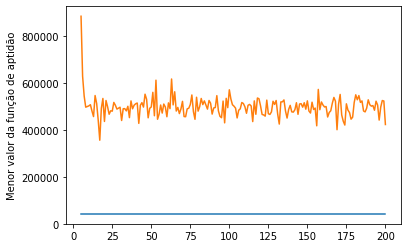

In [ ]:
import matplotlib.pyplot as plt
gen, minVal = log.select("gen", "min")
gen, avgVal = log.select("gen", "avg")
plt.plot(gen[5:], minVal[5:])
plt.plot(gen[5:], avgVal[5:])
plt.ylabel('Menor valor da função de aptidão')
plt.show()

## Utilizando a forma alternativa de resolução do mesmo problema

In [ ]:
# definição da população inicial
population = pop
# quantidade de gerações
NGEN=200
bestIndEachGeneration = []
bestInd = []
for gen in range(NGEN):
  print("Geracao: ", gen)
  offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
  fits = list(toolbox.map(toolbox.evaluate, offspring))
  
  indexes = range(len(offspring))
  indexes = [x for _,x in sorted(zip(fits, indexes))]
  fits = [fits[x] for x in indexes]
  offspring = [offspring[x] for x in indexes]
  print(offspring)
  print(fits)
  for fit, ind in zip(fits, offspring):
    ind.fitness.wvalues = fit
  elites_ind = offspring[:max(1, round(0.15*len(offspring)))]
  population = toolbox.select(offspring, len(population)-len(elites_ind))
  population.extend(elites_ind)
  bestIndEachGeneration.append([offspring[fits.index(min(fits))], min(fits)])
  bestInd.append(min(bestIndEachGeneration, key=lambda t:t[1])[1])
  print(" Melhor Avaliação dessa geração: ", bestIndEachGeneration[-1][1], "\n", 
        "Melhor Avaliação Geral", min(bestIndEachGeneration, key=lambda t:t[1])[1], "\n",
        "Da geração: ", bestIndEachGeneration.index(min(bestIndEachGeneration, key=lambda t:t[1])), "\n",
        "Cromossomo: ", min(bestIndEachGeneration, key=lambda t:t[1])[0], "\n"
       )


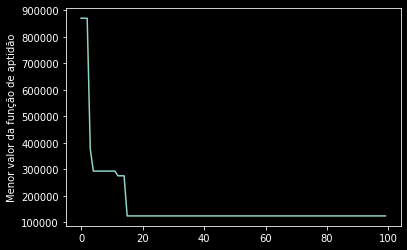

In [ ]:
from matplotlib import style
style.use('dark_background')
import matplotlib.pyplot as plt
plt.plot(bestInd)
plt.ylabel('Menor valor da função de aptidão')
plt.show()